This is playing with pytorch framework for EHR modeling. In general, a patient's health record can be represented as a sequence of visits. Each visit has certain features, and can be represented as a list of medical codes.

For simplicity, we are starting with the data structure that a patient's health record is a list of list, following the line of work from Jimeng Sun's lab. We will use codes from Ed Choi to manipulate the data. 

* This notebook is to present how our logistic regression model works on the cerner sample data for predicting readmission using pytorch library.
* The logistic regression model has the architecture of an embedding layer, a linear activation and sigmoid transformation.
* Our model currently achieves around 0.81 test accuracy.
* Visualization of training loss, training auc, validation auc, and test auc for each epoch as well as how average loss, training auc, validation auc and test auc change with epochs are shown at the end.

In [1]:
from __future__ import print_function, division
from io import open
import string
import re
import random
import pandas as pd
import os
import sys
import argparse
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchviz import make_dot, make_dot_from_trace

from sklearn.metrics import roc_auc_score  
from sklearn.metrics import roc_curve 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

try:
    import cPickle as pickle
except:
    import pickle
    
import operator
from functools import reduce 

In [2]:
# import self-defined modules
# import ehr_pytorch.model as model 
# import ehr.pytorch.Loaddata as Loaddata
# import ehr.pytorch.TrainVeTe as TVT 

import model_em as model #here the em experiment
import Loaddata as Loaddata
import TrainVaTe_em as TVT

# check GPU availability
use_cuda = torch.cuda.is_available()
use_cuda
torch.cuda.set_device(0)

In [3]:
parser = argparse.ArgumentParser(description='30 Hospital Readmission Model with Pytorch: LR, RNN, CNN')
# learning
parser.add_argument('-lr', type=float, default=np.exp(-7.8810), help='initial learning rate [default: 0.0004]')
parser.add_argument('-L2', type=float, default=np.exp(-5.8401), help='L2 regularization [default: 0.003]')
parser.add_argument('-epochs', type=int, default=20, help='number of epochs for train [default: 20]')
parser.add_argument('-batch_size', type=int, default=1, help='batch size for training [default: 1]')
#parser.add_argument('-save-dir', type=str, default='snapshot', help='where to save the snapshot')
#parser.add_argument('-save-best', type=bool, default=True, help='whether to save when get best performance')
# data 
parser.add_argument('-seq_file', type = str, default = 'data/cerner/hospital_data/h143.visits' , help='the path to the Pickled file containing visit information of patients')
parser.add_argument('-label_file', type = str, default = 'data/cerner/hospital_data/h143.labels', help='the path to the Pickled file containing label information of patients')
parser.add_argument('-validation_ratio', type = float, default = 0.1, help='validation data size [default: 0.1]')
parser.add_argument('-test_ratio', type = float, default = 0.2, help='test data size [default: 0.2]')
# model
parser.add_argument('-which_model', type = str, default = 'LR', help='choose from {"LR", "RNN", "CNN"}')
parser.add_argument('-input_size', type = int, default =20000, help='input dimension [default: 20000]')
parser.add_argument('-embed_dim', type=int, default=128, help='number of embedding dimension [default: 128]')
parser.add_argument('-ch_out', type=int, default=64, help='number of each kind of kernel [default; 64]')
parser.add_argument('-kernel_sizes', type=list, default=[3], help='comma-separated kernel size to use for convolution [default:[3]')
parser.add_argument('-dropout', type=float, default=0.1, help='the probability for dropout [default: 0.1]')
parser.add_argument('-eb_mode', type=str, default='sum', help= "embedding mode [default: 'sum']")

_StoreAction(option_strings=['-eb_mode'], dest='eb_mode', nargs=None, const=None, default='sum', type=<class 'str'>, choices=None, help="embedding mode [default: 'sum']", metavar=None)

In [4]:
# a block to simulate args reading from command line 
args = parser.parse_args(args=[])
args.lr = np.exp(-7.8810)
args.L2 = np.exp(-5.8401)
args.epochs = 20
args.batch_size = 1
#args.seq_file = 'data/cerner/hospital_data/h143.visits'
#args.label_file = 'data/cerner/hospital_data/h143.labels'
#args.seq_file = 'Data/h143.visits'
#args.label_file = 'Data/h143.labels'
args.which_model = 'LR'
args.input_size = 20000

In [5]:
def data_load_split_VT(seqFile, labelFile, test_r=0.2 , valid_r=0.1):

   merged_set=[]
   #for h in hosp_list:
       #seqFile= folder+'h'+str(h)+'.visits'
       #labelFile= folder+'h'+str(h)+'.labels'
   set_x = pickle.load(open(seqFile, 'rb'), encoding='bytes')
   set_y = pickle.load(open(labelFile, 'rb'),encoding='bytes')
   merged_set_h = [[set_y[i],set_x[i]] for i in range(len(set_x))] # merge the two lists
       #merged_set_h_f = [[set_y[i],set_x[i][:-1]] for i in range(len(set_x))] # added [:-1] to exclude last visit
       #merged_set_h =[x for x in merged_set_f if len(x[1])>0]

   merged_set.extend(merged_set_h)

   #print (set_y[1],set_x[1][:-1], len(set_x[1][:-1]))

   # set random seed
   random.seed( 3 )

   dataSize = len(merged_set)
   nTest = int(test_r * dataSize)
   nValid = int(valid_r * dataSize)

   random.shuffle(merged_set)

   test_set = merged_set[:nTest]
   valid_set = merged_set[nTest:nTest+nValid]
   train_set = merged_set[nTest+nValid:]

   return train_set, valid_set, test_set

In [12]:
train1 , valid1, test1 = data_load_split_VT(seqFile = 'data2/cerner/unbalanced_data/hf50_all.visitsNN.train', labelFile = 'data2/cerner/unbalanced_data/hf50_all.labels.train')
test_sh_L =[x for x in test1 if len(x[1])< 5]
test_l_L = [x for x in test1 if x not in test_sh_L]
print (len(train1),len(valid1),len(test1))

20063 2865 5731


In [13]:
# load and prepare data
#set_x = pickle.load(open(args.seq_file, 'rb'), encoding='bytes')
#set_y = pickle.load(open(args.label_file, 'rb'),encoding='bytes')

#preprocessing
# LR needs to have input format of list; list of list for NN models
"""
if args.which_model == 'LR':
    model_x = []
    for patient in set_x:
        model_x.append([each for visit in patient for each in visit]) 
"""
#model_x = set_x     

#merged_set= [[set_y[i],model_x[i]] for i in range(len(set_y))] #list of list or list of lists of lists
print("\nLoading and preparing data...")    
#train1, valid1, test1 = Loaddata.load_data(merged_set)
print("\nSample data after split:")  
print(train1[0])
print("model is", args.which_model)

#further processing training, valid, test data format, for the visits information merged into one huge list 

#split the test data according to length
#test_sh_L =[x for x in test1 if len(x[1])< 5]
#test_l_L = [x for x in test1 if x not in test_sh_L]
#print(test_sh_L[0])
#print(test_l_L[0])

train1 = [[train1[i][0],reduce(operator.concat, train1[i][1])] for i in range(len(train1))]
valid1 = [[valid1[i][0],reduce(operator.concat, valid1[i][1])] for i in range(len(valid1))]
test1 = [[test1[i][0],reduce(operator.concat, test1[i][1])] for i in range(len(test1))]
test_sh_L = [[test_sh_L[i][0],reduce(operator.concat, test_sh_L[i][1])] for i in range(len(test_sh_L))]
test_l_L = [[test_l_L[i][0],reduce(operator.concat, test_l_L[i][1])] for i in range(len(test_l_L))]
print('-' * 120)
print('\nAfter flatten:')
print(train1[4])
print(test_sh_L[0])
print(test_l_L[0])


Loading and preparing data...

Sample data after split:
[0, [[16072, 6419, 10916, 1139, 10010, 5703, 16078, 16064, 4778, 12240, 4695, 8354, 5483, 11849, 8283, 11781], [16072, 5703, 16078, 16064, 12240, 11849, 12686, 6102, 9982, 11781], [16072, 6419, 1139, 5703, 16078, 12047, 16064, 4778, 12240, 4695, 11849, 11842, 9982, 8283, 11781]]]
model is LR
------------------------------------------------------------------------------------------------------------------------

After flatten:
[1, [15488, 15379, 14018, 13996, 14510, 14994, 15645, 13839, 14290, 15097, 14873, 14722, 14991, 15006, 14217, 15130, 14725]]
[1, [16067, 16072, 7266, 16078, 7258, 7298]]
[0, [12252, 15091, 13871, 16066, 16071, 15379, 13872, 462, 16078, 9982, 1196, 15130, 15091, 3599, 16066, 11766, 16071, 13872, 16078, 5617, 14970, 9982, 15006, 1196, 250, 256, 467, 14701, 16066, 16071, 7266, 16078, 263, 7687, 15051, 8141, 16066, 16071, 1670, 16078, 14930, 5068, 9982, 189, 14886, 16066, 16071, 14429, 16078, 5736, 14893, 189, 5

Parameter containing:
-9.7543e-01  5.7646e-01
 2.3068e-02 -7.5734e-01
 1.9379e-01 -3.5053e-01
           ⋮            
 1.5295e+00 -6.0164e-01
 3.1049e-02 -2.9489e-01
-9.8487e-02  1.6904e+00
[torch.FloatTensor of size 20000x2]

15815
      emb_0     emb_1                           types
0 -0.975431  0.576456                            Code
1  0.023068 -0.757340  b'M_ACETAMINOPHEN-HYDROCODONE'
2  0.193789 -0.350530         b'M_BACITRACIN TOPICAL'
3 -0.716023  1.243389    b'M_BUPIVACAINE-EPINEPHRINE'
4  0.052831 -0.343788                  b'M_CEFAZOLIN'


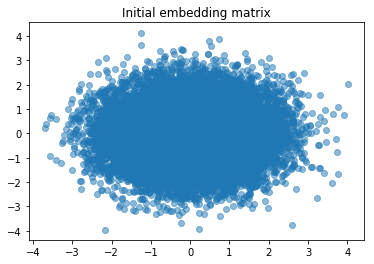

In [14]:
# model loading part
if args.which_model == 'LR': 
    ehr_model = model.EHR_LR(args.input_size)
elif args.which_model == 'RNN':
    ehr_model = model.EHR_RNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode) 
else: 
    ehr_model = model.EHR_CNN(args.input_size, args.embed_dim, args.dropout, args.eb_mode, args.ch_out, args.kernel_sizes)    
if use_cuda:
    ehr_model = ehr_model.cuda()

optimizer = optim.Adam(ehr_model.parameters(), lr=args.lr, weight_decay=args.L2)

In [15]:
## train validation and test part
current_loss_allep=[]
all_losses_allep=[]
avg_losses_allep=[]
train_auc_allep =[]
valid_auc_allep =[]
test_auc_allep = []
test_sh_auc_allep=[]
test_l_auc_allep=[]

In [16]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


 Current running on: Epoch  0 Training loss:  Average loss 0.78075886518084


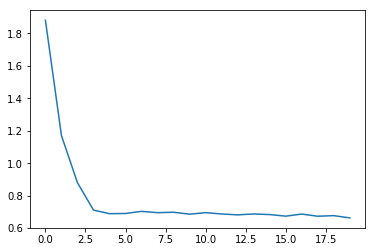

Epoch  0 Summary:  Training_auc : 0.6523845919032129  , Validation_auc :  0.6459025432859804  ,Test_auc :  0.6442737059455971 Test_auc on short visits: 0.6319819221214094 Test_auc on long visits: 0.6555942091951527  Avg Loss:  0.78075886518084 Train Time (0m 33s) Eval Time (0m 20s)


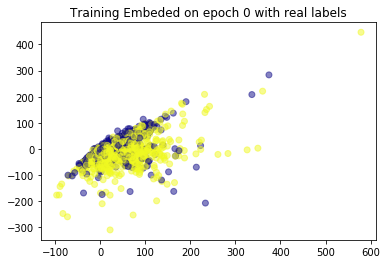

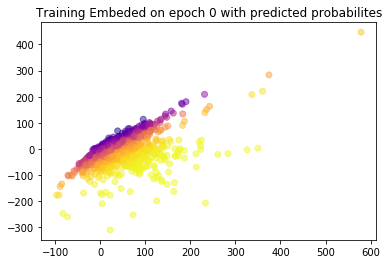


 Current running on: Epoch  1 Training loss:  Average loss 0.6567177975355154


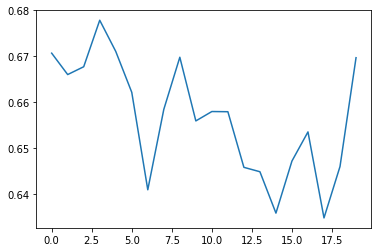

Epoch  1 Summary:  Training_auc : 0.7272880443616759  , Validation_auc :  0.7267257106584382  ,Test_auc :  0.7148351052646615 Test_auc on short visits: 0.6997904786762517 Test_auc on long visits: 0.728007199714494  Avg Loss:  0.6567177975355154 Train Time (0m 33s) Eval Time (0m 20s)


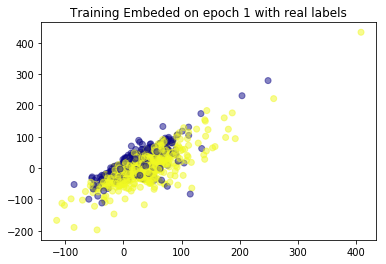

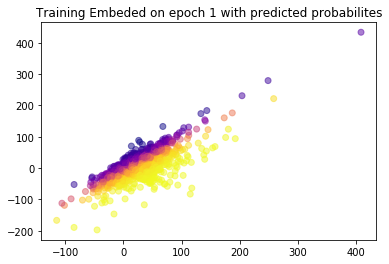


 Current running on: Epoch  2 Training loss:  Average loss 0.6264350238332574


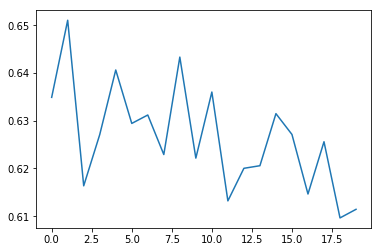

Epoch  2 Summary:  Training_auc : 0.7616827335648808  , Validation_auc :  0.7596449462392851  ,Test_auc :  0.7453568757357611 Test_auc on short visits: 0.7277205544158628 Test_auc on long visits: 0.759453814762518  Avg Loss:  0.6264350238332574 Train Time (0m 33s) Eval Time (0m 20s)


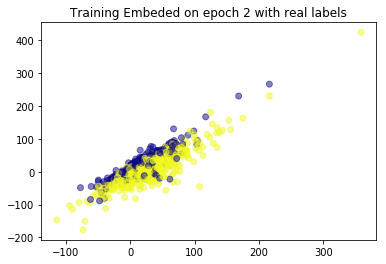

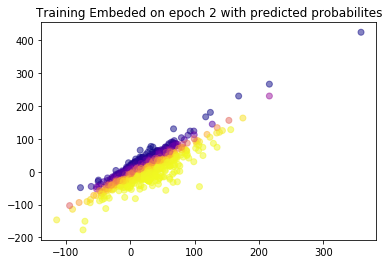


 Current running on: Epoch  3 Training loss:  Average loss 0.6106518200629358


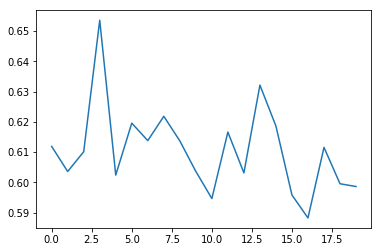

Epoch  3 Summary:  Training_auc : 0.7746466722027429  , Validation_auc :  0.7705150731841925  ,Test_auc :  0.7550852829705839 Test_auc on short visits: 0.7352489587593918 Test_auc on long visits: 0.772124691607057  Avg Loss:  0.6106518200629358 Train Time (0m 33s) Eval Time (0m 20s)


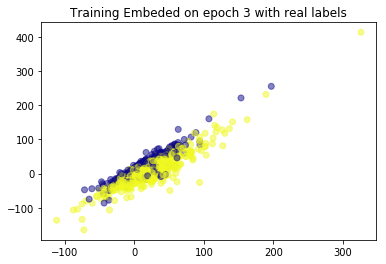

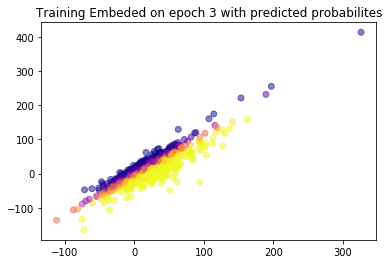


 Current running on: Epoch  4 Training loss:  Average loss 0.6033665862456848


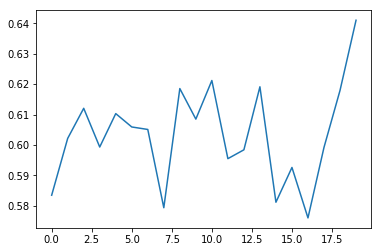

Epoch  4 Summary:  Training_auc : 0.7807024246410033  , Validation_auc :  0.7745879580289071  ,Test_auc :  0.7609326075166614 Test_auc on short visits: 0.7353339052132852 Test_auc on long visits: 0.7806265613604977  Avg Loss:  0.6033665862456848 Train Time (0m 35s) Eval Time (0m 20s)


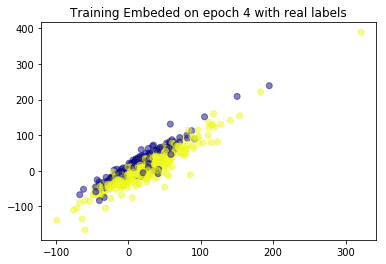

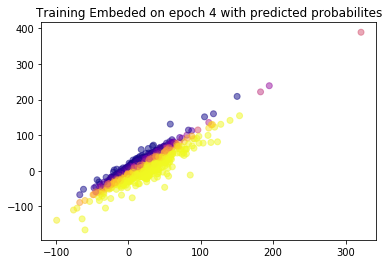


 Current running on: Epoch  5 Training loss:  Average loss 0.5990661914200908


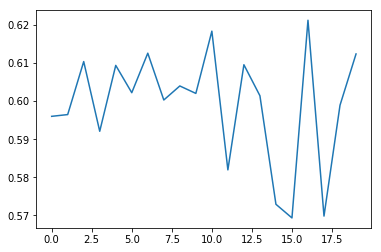

Epoch  5 Summary:  Training_auc : 0.7840267964236017  , Validation_auc :  0.7720481335617607  ,Test_auc :  0.7584003439107121 Test_auc on short visits: 0.7370461631258385 Test_auc on long visits: 0.7765221034338295  Avg Loss:  0.5990661914200908 Train Time (0m 34s) Eval Time (0m 20s)


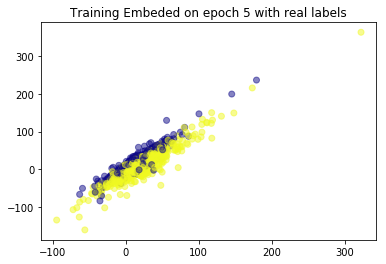

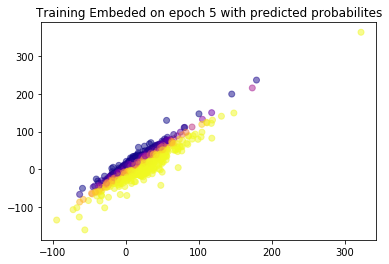


 Current running on: Epoch  6 Training loss:  Average loss 0.5965252223580537


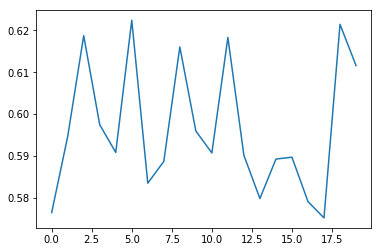

Epoch  6 Summary:  Training_auc : 0.7836407962852295  , Validation_auc :  0.7705355497419466  ,Test_auc :  0.7584540646978974 Test_auc on short visits: 0.735435960320656 Test_auc on long visits: 0.7769584309587723  Avg Loss:  0.5965252223580537 Train Time (0m 33s) Eval Time (0m 19s)


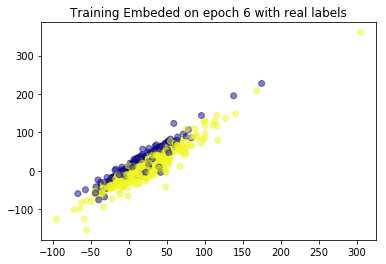

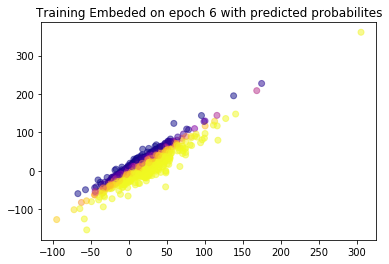


 Current running on: Epoch  7 Training loss:  Average loss 0.5959158724927476


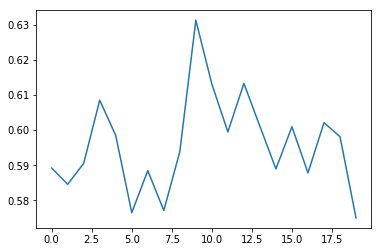

Epoch  7 Summary:  Training_auc : 0.7856100710423317  , Validation_auc :  0.7693430340213131  ,Test_auc :  0.7612713537076745 Test_auc on short visits: 0.7380368735248759 Test_auc on long visits: 0.7810057877015222  Avg Loss:  0.5959158724927476 Train Time (0m 33s) Eval Time (0m 19s)


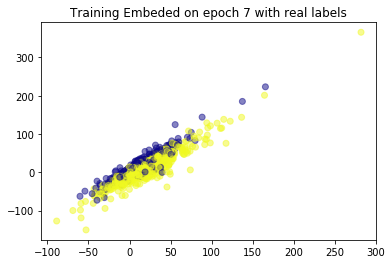

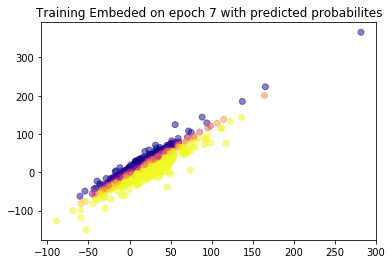


 Current running on: Epoch  8 Training loss:  Average loss 0.5948217683332537


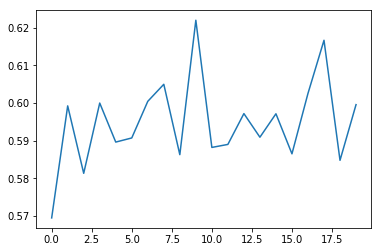

Epoch  8 Summary:  Training_auc : 0.7799203160804629  , Validation_auc :  0.7646865672806059  ,Test_auc :  0.755376535102017 Test_auc on short visits: 0.7287993942740917 Test_auc on long visits: 0.7784294071097181  Avg Loss:  0.5948217683332537 Train Time (0m 33s) Eval Time (0m 19s)


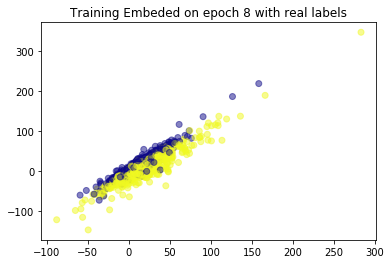

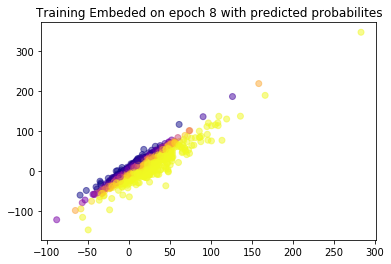


 Current running on: Epoch  9 Training loss:  Average loss 0.5947494821440646


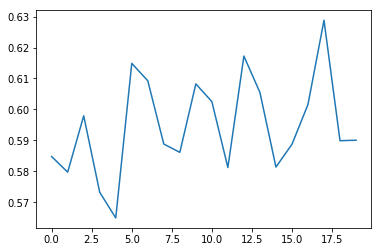

Epoch  9 Summary:  Training_auc : 0.7867419550746081  , Validation_auc :  0.7717197773320605  ,Test_auc :  0.7611799673231103 Test_auc on short visits: 0.733492138772665 Test_auc on long visits: 0.7822229118500473  Avg Loss:  0.5947494821440646 Train Time (0m 33s) Eval Time (0m 19s)


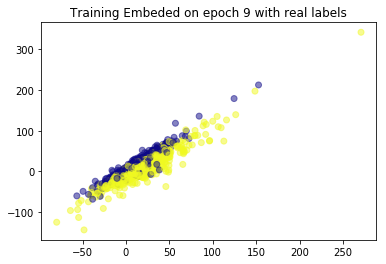

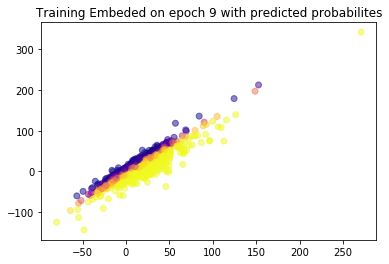


 Current running on: Epoch  10 Training loss:  Average loss 0.594443973723287


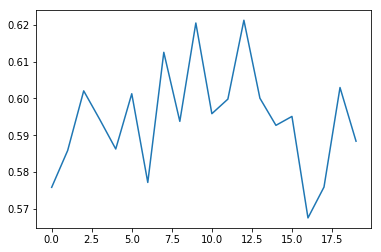

Epoch  10 Summary:  Training_auc : 0.7867790900837318  , Validation_auc :  0.7694244527152403  ,Test_auc :  0.7547505047922606 Test_auc on short visits: 0.7368957661255027 Test_auc on long visits: 0.771192452713082  Avg Loss:  0.594443973723287 Train Time (0m 32s) Eval Time (0m 19s)


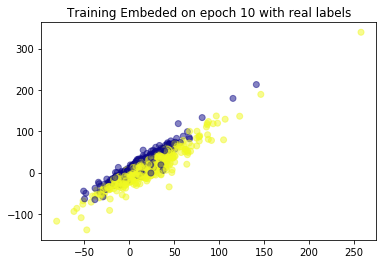

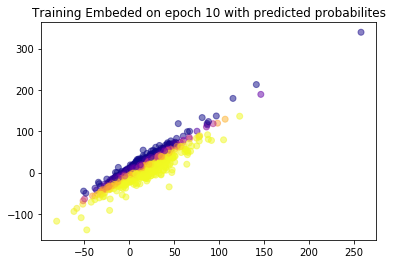


 Current running on: Epoch  11 Training loss:  Average loss 0.593016386523462


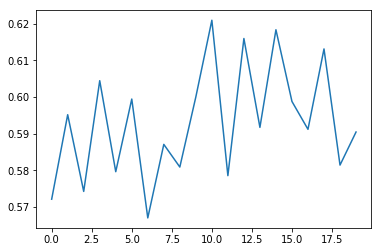

Epoch  11 Summary:  Training_auc : 0.7870859302220792  , Validation_auc :  0.7712117636849224  ,Test_auc :  0.7519465238865817 Test_auc on short visits: 0.7326953927589812 Test_auc on long visits: 0.7700560150200939  Avg Loss:  0.593016386523462 Train Time (0m 32s) Eval Time (0m 20s)


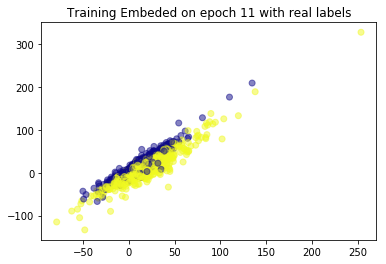

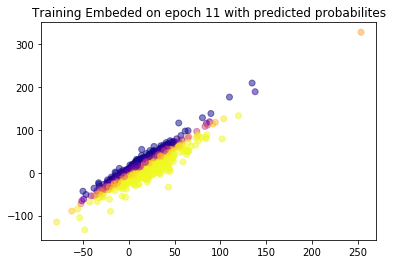


 Current running on: Epoch  12 Training loss:  Average loss 0.5924812678514602


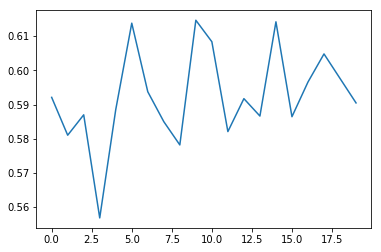

Epoch  12 Summary:  Training_auc : 0.7879432987361401  , Validation_auc :  0.7713921524079945  ,Test_auc :  0.75315273869794 Test_auc on short visits: 0.7306489192901261 Test_auc on long visits: 0.7724852979968035  Avg Loss:  0.5924812678514602 Train Time (0m 32s) Eval Time (0m 20s)


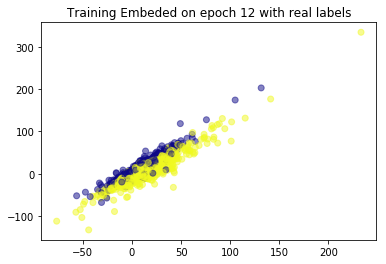

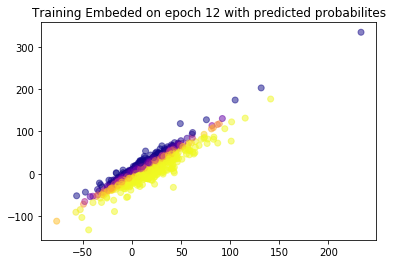


 Current running on: Epoch  13 Training loss:  Average loss 0.592590127730446


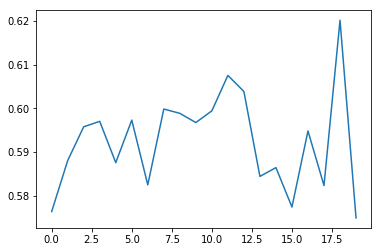

Epoch  13 Summary:  Training_auc : 0.7895910236131699  , Validation_auc :  0.7699490426234176  ,Test_auc :  0.7603098737097549 Test_auc on short visits: 0.7350921957484597 Test_auc on long visits: 0.782130432758701  Avg Loss:  0.592590127730446 Train Time (0m 30s) Eval Time (0m 20s)


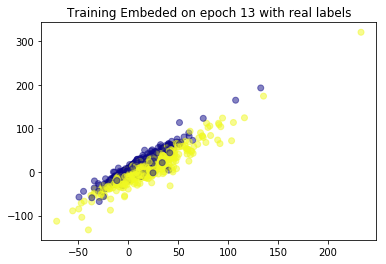

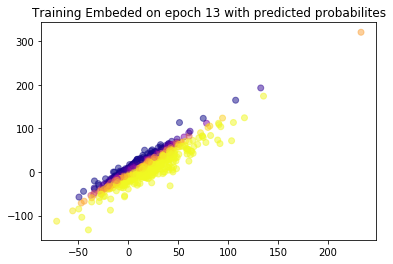


 Current running on: Epoch  14 Training loss:  Average loss 0.5936793670353622


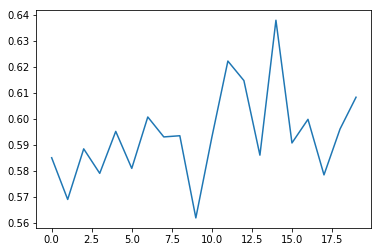

Epoch  14 Summary:  Training_auc : 0.7871653936695997  , Validation_auc :  0.7687592083567757  ,Test_auc :  0.7524574818283332 Test_auc on short visits: 0.7302552213223159 Test_auc on long visits: 0.7714754759725045  Avg Loss:  0.5936793670353622 Train Time (0m 31s) Eval Time (0m 17s)


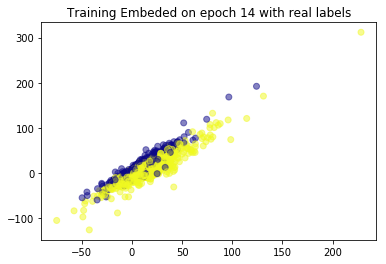

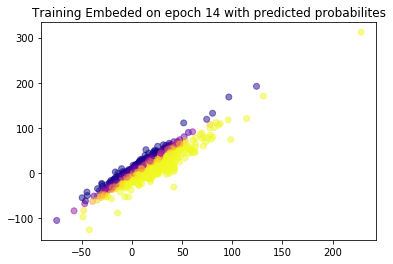


 Current running on: Epoch  15 Training loss:  Average loss 0.5914417166089078


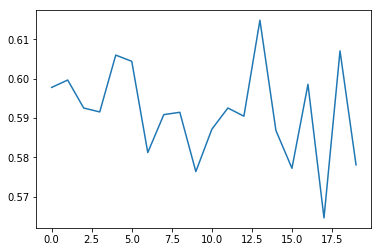

Epoch  15 Summary:  Training_auc : 0.7875220688409545  , Validation_auc :  0.7666562171217175  ,Test_auc :  0.7528619749372992 Test_auc on short visits: 0.7304197429086622 Test_auc on long visits: 0.7721194159541949  Avg Loss:  0.5914417166089078 Train Time (1m 1s) Eval Time (0m 24s)


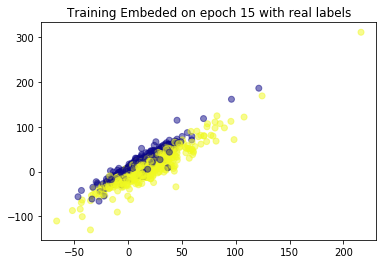

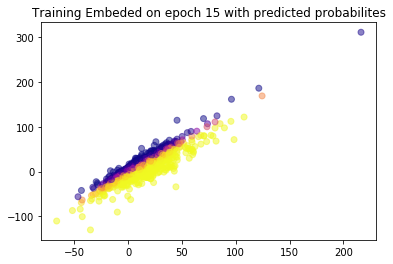


 Current running on: Epoch  16 Training loss:  Average loss 0.5935497484846649


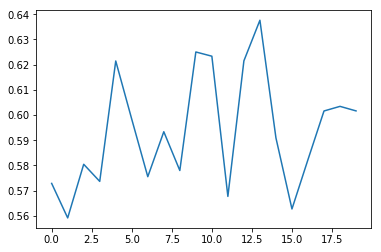

Epoch  16 Summary:  Training_auc : 0.7918809130351115  , Validation_auc :  0.7700455749671156  ,Test_auc :  0.7572219051881827 Test_auc on short visits: 0.7345212441731108 Test_auc on long visits: 0.777690505376511  Avg Loss:  0.5935497484846649 Train Time (0m 30s) Eval Time (0m 17s)


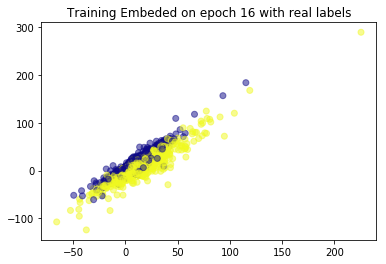

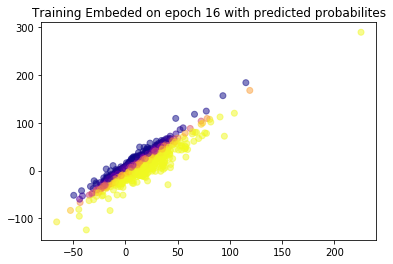


 Current running on: Epoch  17 Training loss:  Average loss 0.5913889403796211


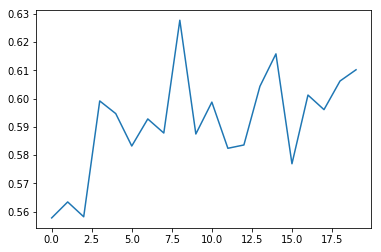

Epoch  17 Summary:  Training_auc : 0.7909202927796748  , Validation_auc :  0.7701079797145567  ,Test_auc :  0.7585714568271673 Test_auc on short visits: 0.73386733552218 Test_auc on long visits: 0.7796111533508153  Avg Loss:  0.5913889403796211 Train Time (0m 25s) Eval Time (0m 17s)


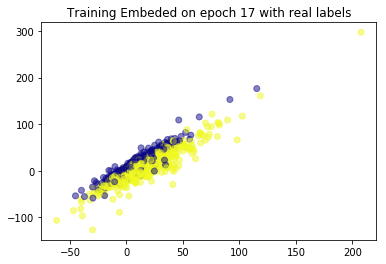

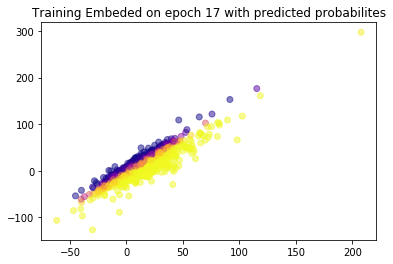


 Current running on: Epoch  18 Training loss:  Average loss 0.5920189291121626


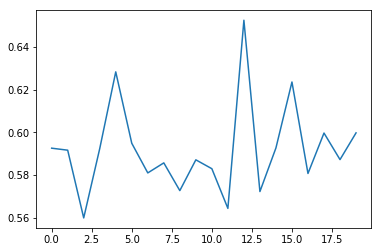

Epoch  18 Summary:  Training_auc : 0.7916782449297256  , Validation_auc :  0.7709521501848253  ,Test_auc :  0.7580164234213841 Test_auc on short visits: 0.7334010252460065 Test_auc on long visits: 0.778545471472683  Avg Loss:  0.5920189291121626 Train Time (0m 28s) Eval Time (0m 17s)


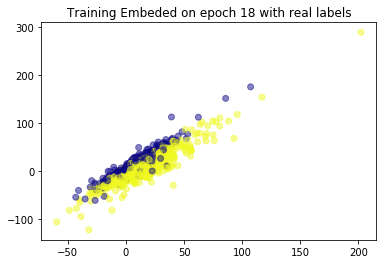

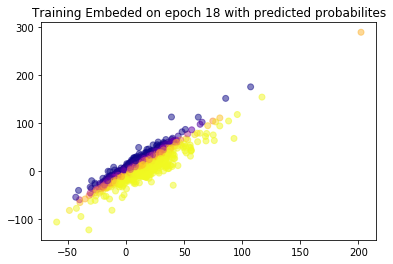


 Current running on: Epoch  19 Training loss:  Average loss 0.5912013511412871


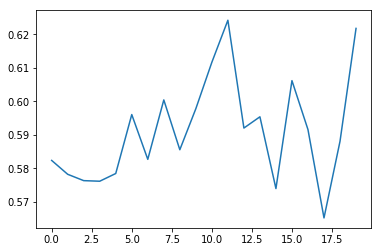

Epoch  19 Summary:  Training_auc : 0.7893183834999697  , Validation_auc :  0.7665635850747344  ,Test_auc :  0.7533594416359055 Test_auc on short visits: 0.733798105156946 Test_auc on long visits: 0.7760795692584604  Avg Loss:  0.5912013511412871 Train Time (0m 28s) Eval Time (0m 17s)


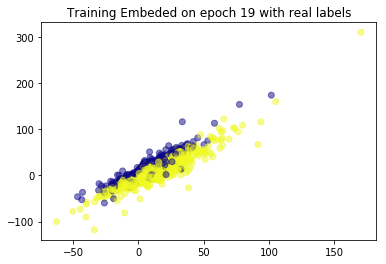

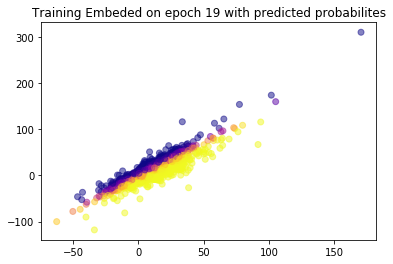

In [17]:
# train, validation, and test for each epoch 
for ep in range(args.epochs):
    start = time.time()
    current_loss, train_loss, em = TVT.train(train1, model= ehr_model, optimizer = optimizer, batch_size = args.batch_size) #mb=args.mb
    avg_loss = np.mean(train_loss)
    train_time = timeSince(start)
    print ('\n Current running on: Epoch ', ep,'Training loss:',' Average loss', avg_loss)
    #print(train_loss, '\n train loss plot')
    TVT.showPlot(train_loss)
    eval_start = time.time()
    train_auc, y_real, y_hat, emb = TVT.calculate_auc(model= ehr_model, data = train1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' Training auc:', train_auc)
    #TVT.auc_plot(y_real, y_hat)
    valid_auc, _, _, _  = TVT.calculate_auc(model = ehr_model, data = valid1, which_model = args.which_model, batch_size = args.batch_size)
    #print ('\n Current running on: Epoch ', ep,' validation auc:', valid_auc)
    #TVT.auc_plot(y_real, y_hat)
    test_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test1, which_model = args.which_model, batch_size = args.batch_size)
    shorttest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_sh_L, which_model = args.which_model, batch_size = args.batch_size)
    longtest_auc, _, _, _ = TVT.calculate_auc(model = ehr_model, data = test_l_L, which_model = args.which_model, batch_size = args.batch_size) 
    #print ('\n Current running on: Epoch ', ep,' test auc:', test_auc)
    #TVT.auc_plot(y_real, y_hat)
    eval_time = timeSince(eval_start)
    print ("Epoch ", ep, "Summary:  Training_auc :", train_auc, " , Validation_auc : ", valid_auc, " ,Test_auc : " , test_auc, 
           "Test_auc on short visits:",shorttest_auc, "Test_auc on long visits:", longtest_auc," Avg Loss: ", avg_loss, 'Train Time (%s) Eval Time (%s)'%(train_time,eval_time) )
    current_loss_allep.append(current_loss)
    all_losses_allep.append(train_loss)
    avg_losses_allep.append(avg_loss)
    train_auc_allep.append(train_auc)
    valid_auc_allep.append(valid_auc)
    test_auc_allep.append(test_auc)
    test_sh_auc_allep.append(shorttest_auc)
    test_l_auc_allep.append(longtest_auc)
  
    color1 = np.array([item for item in y_real])
    plt.figure()
    plt.scatter(emb[1:,0],emb[1:,1], c= color1, cmap= 'plasma', alpha = 0.5)
    plt.title('Training Embeded on epoch '+str(ep)+' with real labels')
    plt.show()
    color2 = np.array([item for item in y_hat])
    plt.scatter(emb[1:,0],emb[1:,1], c= color2, cmap='plasma', alpha = 0.5)
    plt.title('Training Embeded on epoch '+str(ep)+' with predicted probabilites')
    plt.show()

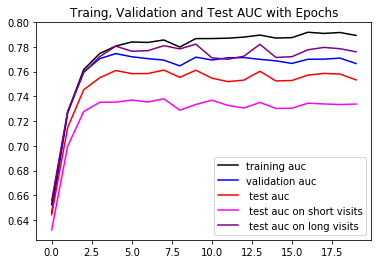

In [19]:
#plot all three auc in a same plot 
plt.plot(train_auc_allep, color= 'black', label = 'training auc')
plt.plot(valid_auc_allep, color ='blue', label = 'validation auc')
plt.plot(test_auc_allep, color = 'red', label =' test auc')
plt.plot(test_sh_auc_allep, color = 'magenta', label =' test auc on short visits')
plt.plot(test_l_auc_allep, color = 'purple', label =' test auc on long visits')
plt.title('Traing, Validation and Test AUC with Epochs' )
plt.legend(loc= 'lower right')
plt.show()

In [21]:
import plotly.plotly as py 
import plotly.graph_objs as go
py.sign_in('GinnyJZ','xJj3WJ9XiB3ijm4frOXc') #get my own sign in please

train_auc_fg= go.Scatter(x= np.arange(args.epochs), y=train_auc_allep, name ='Training auc')
valid_auc_fg= go.Scatter(x= np.arange(args.epochs), y=valid_auc_allep, name ='Validation auc')
test_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_auc_allep, name ='Test auc')
test_sh_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_sh_auc_allep, name ='Test auc on <5 visits)')
test_l_auc_fg= go.Scatter(x= np.arange(args.epochs), y=test_l_auc_allep, name ='Test auc on >=5 visits)')

valid_max = max(valid_auc_allep)
test_max = max(test_auc_allep)

data = [train_auc_fg, valid_auc_fg, test_auc_fg, test_sh_auc_fg, test_l_auc_fg]#,valid_auc_allep,test_auc_allep] 
layout = go.Layout(showlegend= True, xaxis=dict(dtick=1))
layout.update(dict(annotations=[go.Annotation(text="Max Valid", x=valid_auc_allep.index(valid_max), y=valid_max)]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='LR_Auc_dim2_hf50_balanced')
#url = py.plot(data, filename='some-data')  # gen. online plot
#py.image.save_as(data, 'some-data.png')